To dos: 
    
    1) EDA on test see if it's similar with train
    
    2) FE add time compmenets according to different region e.g. day of week etc
    
    3) test impression list length

In [1]:
import pandas as pd
import numpy as np
from utils import load_data

In [2]:
%%time
train = load_data('train', nrows=int(1e6))

CPU times: user 2.49 s, sys: 145 ms, total: 2.63 s
Wall time: 1.8 s


total train shape: (15,932,992, 12)

In [36]:
train.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,00RL8Z82B2Z1,aff3928535f48,1541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


### session and user ids count

In [38]:
sids = train.session_id.unique()
uids = train.user_id.unique()
print(f'number of unique sessions: {len(sids):,} | users: {len(uids):,}')
multiple_users = train.drop_duplicates(subset=['user_id', 'session_id']).user_id.duplicated().sum()
mu_per = multiple_users/len(uids)
print(f'{multiple_users:,} users has different sessions which is {mu_per*100:.2f}% of all users')

number of unique sessions: 57,238 | users: 56,134
1104 users has different sessions which is 1.97% of all users


### demos

In [31]:
sid = np.random.choice(sids, 1)[0]
print(f'demo: {sid}')
train[train.session_id==sid]

demo: f45e71ced3051


,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
22313,OQN7QECT0UC9,f45e71ced3051,1541176956,1,search for destination,"Sète, France",NL,"Sète, France",mobile,NaN,NaN,NaN
22314,OQN7QECT0UC9,f45e71ced3051,1541177030,2,search for destination,"Vendargues, France",NL,"Vendargues, France",mobile,NaN,NaN,NaN
22315,OQN7QECT0UC9,f45e71ced3051,1541177210,3,search for item,6306720,NL,"Montpellier, France",mobile,NaN,NaN,NaN
22316,OQN7QECT0UC9,f45e71ced3051,1541177236,4,interaction item image,6306720,NL,"Montpellier, France",mobile,NaN,NaN,NaN
22317,OQN7QECT0UC9,f45e71ced3051,1541177236,5,interaction item image,6306720,NL,"Montpellier, France",mobile,NaN,NaN,NaN
22318,OQN7QECT0UC9,f45e71ced3051,1541177236,6,interaction item image,6306720,NL,"Montpellier, France",mobile,NaN,NaN,NaN
22319,OQN7QECT0UC9,f45e71ced3051,1541177256,7,clickout item,86207,NL,"Montpellier, France",mobile,NaN,6306720|86207|107431|3137636|2175050|7157020|4...,60|77|36|130|107|48|61|84|99|92|93|92|67|63|10...
22320,OQN7QECT0UC9,f45e71ced3051,1541177573,8,clickout item,4441432,NL,"Montpellier, France",mobile,NaN,4441432|49702|107431|3137636|86207|2175050|715...,77|61|36|130|77|107|48|84|99|92|78|93|92|67|63...
22321,OQN7QECT0UC9,f45e71ced3051,1541177694,9,search for destination,"Lunel, France",NL,"Lunel, France",mobile,NaN,NaN,NaN
22322,OQN7QECT0UC9,f45e71ced3051,1541177716,10,clickout item,341026,NL,"Lunel, France",mobile,NaN,341026|8127134|2880700|2175752|735266|4401604|...,78|93|75|46|70|68|90|61|56|96|56|90|67|101|61|...


### session size distribution

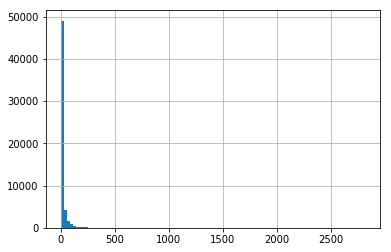

In [85]:
_ = train.groupby('session_id').size().hist(bins=100)

In [86]:
train.groupby('session_id').size().describe()

count    57238.000000
mean        17.470911
std         48.017363
min          1.000000
25%          2.000000
50%          4.000000
75%         13.000000
max       2816.000000
dtype: float64

In [149]:
train[(train.session_id=='948641e533837') & (train.action_type=='clickout item')]

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices,nimps
269105,A5ZFRVCM2Z1L,948641e533837,1541161087,1008,clickout item,1943607,TR,"Istanbul, Turkey",mobile,Breakfast Included,2158560|3491116|112764|1707617|922215|2259250|...,37|38|38|34|29|31|35|36|38|33|26|33|28|34|34|3...,25


*notes*: there is a max 2816 session length session_id=948641e533837

### value counts of action_types

In [39]:
train.action_type.value_counts()

interaction item image     743268
clickout item               99872
filter selection            44226
search for destination      25304
change of sort order        24934
interaction item info       17955
interaction item rating     13736
interaction item deals      12194
search for item              9824
search for poi               8687
Name: action_type, dtype: int64

In [41]:
train.action_type.value_counts(normalize=True)*100

interaction item image     74.3268
clickout item               9.9872
filter selection            4.4226
search for destination      2.5304
change of sort order        2.4934
interaction item info       1.7955
interaction item rating     1.3736
interaction item deals      1.2194
search for item             0.9824
search for poi              0.8687
Name: action_type, dtype: float64

In [50]:
# train.groupby('action_type')['reference'].value_counts()
action_ref_ctns = lambda col: train[train.action_type==col]['reference'].value_counts()
action_ref_ctns('change of sort order')

interaction sort button     14589
price only                   4948
price and recommended        2725
distance only                 736
distance and recommended      636
rating and recommended        623
rating only                   436
our recommendations           241
Name: reference, dtype: int64

### action counts per reference

In [55]:
train.groupby('reference')['action_type'].value_counts().head()

reference                               action_type           
1 Star                                  filter selection          200
1 Utama                                 search for poi              1
1000 Schritte durch 1000 Jahre Bautzen  search for poi              1
1000029                                 interaction item image      9
10000338                                search for item             1
Name: action_type, dtype: int64

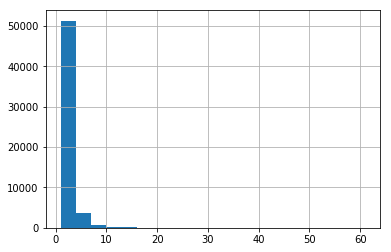

In [70]:
train[train.action_type == 'clickout item'].groupby('reference').size().hist(bins=20)

In [76]:
train.groupby('action_type')['reference'].value_counts().groupby(level=0).head(2)

action_type              reference              
change of sort order     interaction sort button    14589
                         price only                  4948
clickout item            8796                          61
                         8621                          58
filter selection         Sort by Price               4950
                         Hotel                       3752
interaction item deals   3414162                       23
                         1488631                       15
interaction item image   8796                         478
                         2053822                      425
interaction item info    unknown                       32
                         34506                         24
interaction item rating  34506                         26
                         499361                        18
search for destination   London, United Kingdom       369
                         Paris, France                322
search for item        

*notes*: majority references only had one clickout, using this to encode would probably be leakage, overfits or maybe not?

### value counts for divices/platform

In [64]:
train.device.value_counts()

mobile     489604
desktop    428813
tablet      81583
Name: device, dtype: int64

In [66]:
train.platform.value_counts().head()

BR    161212
US    103517
DE     62969
UK     56013
MX     51006
Name: platform, dtype: int64

popularity of references for different devices

In [72]:
train[train.action_type == 'clickout item'].groupby('device')['reference'].value_counts().groupby(level=0).head(5)

device   reference
desktop  8246692      37
         8796         26
         1811137      25
         8621         23
         8586         18
mobile   8564         32
         8561         31
         8589         28
         8621         26
         8796         26
tablet   2123918      15
         8621          9
         8796          9
         953525        9
         321586        8
Name: reference, dtype: int64

### length of impression

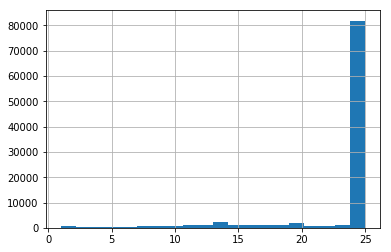

In [96]:
has_imp_mask = train.impressions.notna()
train.loc[has_imp_mask, 'nimps']= train.loc[has_imp_mask, 'impressions'].str.split('|').str.len()#.hist(bins=20)
train[has_imp_mask].impressions.str.split('|').str.len().hist(bins=20)

### location and price of clickout item

In [132]:
%%time
def get_ind(x):
    try:
        imps = x.impressions.split('|')
        return imps.index(str(x.reference))/len(imps)
    except:
        return np.nan
        
loc_ind_per = train[(train.reference.notna()) & (train.impressions.notna())].apply(get_ind, axis=1)

CPU times: user 2.43 s, sys: 8.29 ms, total: 2.44 s
Wall time: 2.44 s


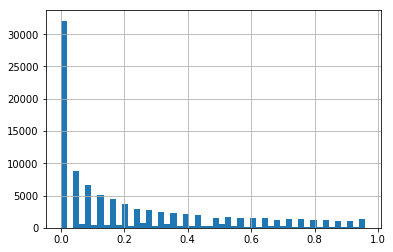

In [133]:
_ = loc_ind_per.hist(bins=50)

In [140]:
%%time
def get_ind(x):
    try:
        imps = x.impressions.split('|')
        ps = x.prices.split('|')
        ps = [float(p) for p in ps]
        return ps[imps.index(x.reference)]/max(ps)
    except:
        return np.nan     
price_loc = train[(train.reference.notna()) & (train.impressions.notna())].apply(get_ind, axis=1)

CPU times: user 3.82 s, sys: 5.17 ms, total: 3.82 s
Wall time: 3.82 s


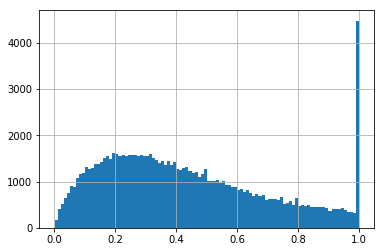

In [142]:
_ = price_loc.hist(bins=100)

### popularity for different scenarios

In [3]:
train.head()

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,008UN2RY0DMY,cd10940538005,1541031243,1,search for destination,"Rochester, USA",US,"Rochester, USA",desktop,NaN,NaN,NaN
1,008UN2RY0DMY,cd10940538005,1541031463,2,change of sort order,interaction sort button,US,"Rochester, USA",desktop,NaN,NaN,NaN
2,008UN2RY0DMY,cd10940538005,1541031473,3,change of sort order,distance and recommended,US,"Rochester, USA",desktop,NaN,NaN,NaN
3,008UN2RY0DMY,cd10940538005,1541031473,4,filter selection,Focus on Distance,US,"Rochester, USA",desktop,Focus on Distance,NaN,NaN
4,008UN2RY0DMY,cd10940538005,1541031550,5,interaction item image,57103,US,"Rochester, USA",desktop,NaN,NaN,NaN


In [5]:
train.groupby(['platform', 'city']).size().head()

platform  city                           
AA        10th of Ramadan City, Egypt         1
          Abu Dhabi, United Arab Emirates    11
          Addis Ababa, Ethiopia              22
          Agadir, Morocco                     4
          Ain Sukhna, Egypt                  22
dtype: int64

In [6]:
def get_specific_popularity(df):
    return df.groupby('reference')['action_type'].value_counts()


In [ ]:
%%time
a = train.groupby(['platform', 'city']).apply(get_specific_popularity)

In [15]:
grp = train.groupby(['platform', 'city'])
for i, j in grp:
    if len(j) > 1:
        print(i)

        print(j.to_string())
        break

('AA', 'Abu Dhabi, United Arab Emirates')
             user_id     session_id   timestamp  step             action_type                        reference platform                             city   device current_filters                                        impressions                                             prices
100965  FEYP3TLB8JL3  01588cfb1bce0  1541074177     1  search for destination  Abu Dhabi, United Arab Emirates       AA  Abu Dhabi, United Arab Emirates  desktop             NaN                                                NaN                                                NaN
100966  FEYP3TLB8JL3  01588cfb1bce0  1541074245     2  interaction item image                            55347       AA  Abu Dhabi, United Arab Emirates  desktop             NaN                                                NaN                                                NaN
100967  FEYP3TLB8JL3  01588cfb1bce0  1541074245     3  interaction item image                            55347       A

In [11]:
a.loc['AA']

city                             reference                        action_type           
10th of Ramadan City, Egypt      2431048                          clickout item              1
Abu Dhabi, United Arab Emirates  55347                            interaction item image     8
                                                                  clickout item              1
                                 Abu Dhabi, United Arab Emirates  search for destination     2
Addis Ababa, Ethiopia            1204212                          interaction item image    11
                                                                  clickout item              2
                                                                  interaction item deals     1
                                 4505162                          interaction item image     6
                                 5003510                          clickout item              1
                                 interaction sort button